# 1. Using a pre-trained convnet

## 1.1 Feature extraction

### 1.1.1 Instantiating the VGG16 convolutional base

In [1]:
from keras.applications import VGG16

conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(150, 150, 3))

Using TensorFlow backend.


### 1.1.2 Displaying a summary of the convolutional base

In [2]:
conv_base.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

### 1.1.3 Extracting features using the pre-trained convolutional base

In [3]:
import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator

base_dir = './data/cats_and_dogs_small'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

datagen = ImageDataGenerator(rescale=1./255)
batch_size = 20

def extract_features(directory, sample_count):
    features = np.zeros(shape= (sample_count, 4, 4, 512))
    labels = np.zeros(shape= (sample_count))
    generator = datagen.flow_from_directory(
        directory, 
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='binary')
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            # Note that since generators yield data indefinitely in a loop
            # we must 'break' after every image has been seen once.
            break
    return features, labels

In [4]:
train_features, train_labels = extract_features(train_dir, 2000)
validation_features, validation_labels = extract_features(validation_dir, 1000)
test_features, test_labels = extract_features(test_dir, 1000)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [5]:
train_features = np.reshape(train_features, (2000, 4 * 4 * 512))
validation_features = np.reshape(validation_features, (1000, 4 * 4 * 512))
test_features = np.reshape(test_features, (1000, 4 * 4 * 512))

In [6]:
from keras import models
from keras import layers
from keras import optimizers

model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_dim=4 * 4 * 512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer=optimizers.RMSprop(lr=1e-4),
              loss='binary_crossentropy',
              metrics=['acc'])

history = model.fit(train_features, train_labels,
                    epochs=30, 
                    batch_size=20,
                    validation_data=(validation_features, validation_labels))

Train on 2000 samples, validate on 1000 samples
Epoch 1/30
2000/2000 [==============================] - 1s - loss: 0.4655 - acc: 0.7750 - val_loss: 0.3131 - val_acc: 0.8670
Epoch 2/30
2000/2000 [==============================] - 1s - loss: 0.2932 - acc: 0.8685 - val_loss: 0.2591 - val_acc: 0.8930
Epoch 3/30
2000/2000 [==============================] - 1s - loss: 0.2365 - acc: 0.9030 - val_loss: 0.2698 - val_acc: 0.8930
Epoch 4/30
2000/2000 [==============================] - 1s - loss: 0.2091 - acc: 0.9160 - val_loss: 0.2439 - val_acc: 0.9030
Epoch 5/30
2000/2000 [==============================] - 1s - loss: 0.1760 - acc: 0.9330 - val_loss: 0.2366 - val_acc: 0.9050
Epoch 6/30
2000/2000 [==============================] - 1s - loss: 0.1584 - acc: 0.9380 - val_loss: 0.2477 - val_acc: 0.9000
Epoch 7/30
2000/2000 [==============================] - 1s - loss: 0.1362 - acc: 0.9540 - val_loss: 0.2480 - val_acc: 0.9010
Epoch 8/30
2000/2000 [==============================] - 1s - loss: 0.1244 - a

### 1.1.4 Plotting our results

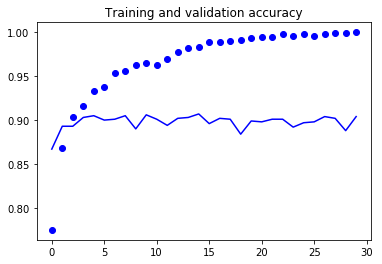

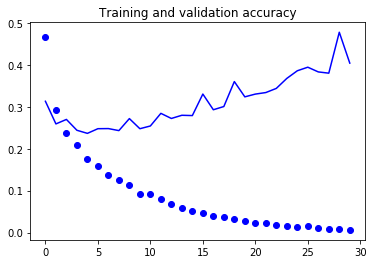

In [7]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and validation accuracy')

plt.figure()

plt.plot(epochs, loss, 'bo')
plt.plot(epochs, val_loss, 'b')
plt.title('Training and validation accuracy')

plt.show()

### 1.1.5 Adding a densely-connected classifier on top of the convolutional base

In [8]:
from keras import models
from keras import layers

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

### 1.1.6 Summary of the extended model

In [9]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 16,812,353
Non-trainable params: 0
_________________________________________________________________


In [10]:
print('This is the number of trainable weights '
      'before freezing the conv base: ', len(model.trainable_weights))

This is the number of trainable weights before freezing the conv base:  30


In [11]:
conv_base.trainable = False

In [12]:
print('This is the number of trainable weights '
      'after freezing the conv base: ', len(model.trainable_weights))

This is the number of trainable weights after freezing the conv base:  4


### 1.1.7 Training the model end-to-end with a frozen convolutional base

In [15]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

# Note that the validation data should not be augmented!
validation_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        # All images will be resized to 150x150
        target_size=(150, 150),
        batch_size=20,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

validation_generator = validation_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])

history = model.fit_generator(
    train_generator,
    steps_per_epoch=100,
    epochs=50,
    validation_data=validation_generator,
    validation_steps=50)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Epoch 1/50
100/100 [==============================] - 75s - loss: 0.4661 - acc: 0.7875 - val_loss: 0.2384 - val_acc: 0.9020
Epoch 2/50
 43/100 [===========>..................] - ETA: 37s - loss: 0.3594 - acc: 0.8221

KeyboardInterrupt: 

### 1.1.8 Plotting our results

In [ ]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and validation accuracy')

plt.figure()

plt.plot(epochs, loss, 'bo')
plt.plot(epochs, val_loss, 'b')
plt.title('Training and validation accuracy')

plt.show()